In [53]:
import pickle
import numpy as np
import sys
sys.path.insert(0, '/home/abrahamn/21cmIRxcor/')
import cat_utils

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io.votable import parse
from astropy.table import Table

In [54]:
d = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57639/whole_field/'
sefluxname = 'best'
secat = pickle.load( open(d+'whole_field_secat_'+sefluxname+'.p', "rb" ) )
g = secat.jy>1.e-10
secat = cat_utils.Catalog(secat.ra[g],secat.dec[g],secat.jy[g])

In [55]:
# apass cat
apasscatdat = np.genfromtxt('/home/abrahamn/xcor_data/ir_catalogs/apass_6degcat.csv',skip_header=2,delimiter=',')
has_iprime_mag = np.logical_not(np.isnan(apasscatdat[:,23]))
apass_cat = cat_utils.Catalog(apasscatdat[has_iprime_mag,2],apasscatdat[has_iprime_mag,3],3631.*10.**(-apasscatdat[has_iprime_mag,23]/2.5))

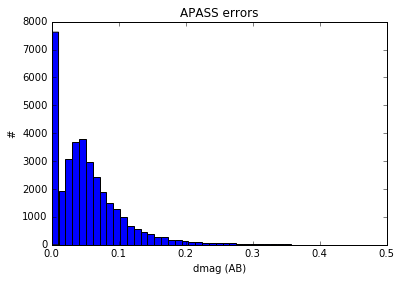

In [56]:
h = plt.hist(apasscatdat[has_iprime_mag,24],np.linspace(0,.5))
plt.xlabel('dmag (AB)')
plt.ylabel('#')
plt.title('APASS errors')

In [57]:
# dophot cat
dophot_cat = cat_utils.IRCatalog('/home/abrahamn/xcor_data/ATLAS_mwa57694_rereduction/02a57694o0281I.dph')
dophot_cat.ra = dophot_cat.ra_all
dophot_cat.dec = dophot_cat.dec_all
dophot_cat.jy = dophot_cat.jy_all

loading /home/abrahamn/xcor_data/ATLAS_mwa57694_rereduction/02a57694o0281I.dph


In [58]:
# plt.plot(dophot_cat.ra_all,dophot_cat.dec_all,'.')

In [59]:
# to get early skymapper data, do a cone search through an australian proxy
# http://skymapper.anu.edu.au.prx.teleport.to/edr_cone/query?RA=1&DEC=-29&SR=.35&VERB=2

# need to edit the xml file and change datatypes "character(18)" and "character(3)" to "char"
catdir = '/home/abrahamn/xcor_data/ir_catalogs/'
skymappercatraw = parse(catdir + 'view-source_skymapper.anu.edu.au.prx.teleport.to_edr_cone_query_RA=1&DEC=-29&SR=.35&VERB=2.xml').get_first_table().array

In [60]:
# skymappercat.dtype

In [61]:
# http://skymapper.anu.edu.au/table-browser/
ra = skymappercatraw['raj2000']
dec = skymappercatraw['dej2000']
flags = skymappercatraw['flags']
ab_mag_psf = skymappercatraw['i_psf'] # mag measured by psf fitting
ab_mag_petro = skymappercatraw['i_petro'] # mag measured in an azimuthally averaged radius, see http://www.sdss.org/dr12/algorithms/magnitudes/#mag_petro

jy_psf = 3631.*10.**(-ab_mag_psf/2.5)
jy_petro = 3631.*10.**(-ab_mag_petro/2.5)

skymapper_cat = cat_utils.Catalog(ra,dec,jy_psf)

In [62]:
secat = secat.bound_with_cat(skymapper_cat)
dophot_cat = dophot_cat.bound_with_cat(skymapper_cat)
apass_cat = apass_cat.bound_with_cat(skymapper_cat)

In [63]:
# plt.figure(figsize=(20,15))
# plt.scatter(ra,dec,25000*skymapper_cat.jy,edgecolor='none',facecolor='red')

# plt.scatter(secat_bounded.ra,secat_bounded.dec,25000*secat_bounded.jy,facecolor='none')
# plt.scatter(dophot_cat_bounded.ra,dophot_cat_bounded.dec,25000*dophot_cat_bounded.jy,facecolor='none',edgecolor='blue')

# plt.scatter(apass_cat_bounded.ra,apass_cat_bounded.dec,25000*apass_cat_bounded.jy,facecolor='none',edgecolor='cyan')

In [70]:
# for each sextractor source, look for matching dophot and source extractor sources

cats = [apass_cat,dophot_cat,skymapper_cat]
catnames = ['APASS','ATLAS/dophot','skymapper']
indices_matching_srcs = np.zeros((len(cats),len(secat.jy)),dtype=int)-1 # -1 if no match
for cati in range(len(cats)):
    for i in range(len(secat.jy)):
        if i % 100 == 0: print('%f'%(1.*i/len(apass_cat.jy)))
        asec_to_all_cat_sources = np.sqrt((secat.dec[i]-cats[cati].dec)**2+np.sin(secat.dec[i]*np.pi/180)**2*(secat.ra[i]-cats[cati].ra)**2)*3600.
        if np.min(asec_to_all_cat_sources) < 1:
            indices_matching_srcs[cati,i] = np.argmin(asec_to_all_cat_sources)

0.000000
0.510204
1.020408
1.530612
2.040816
0.000000
0.510204
1.020408
1.530612
2.040816
0.000000
0.510204
1.020408
1.530612
2.040816


In [71]:
def jy2mag(jy):
    return -2.5*np.log10(jy/3631.)

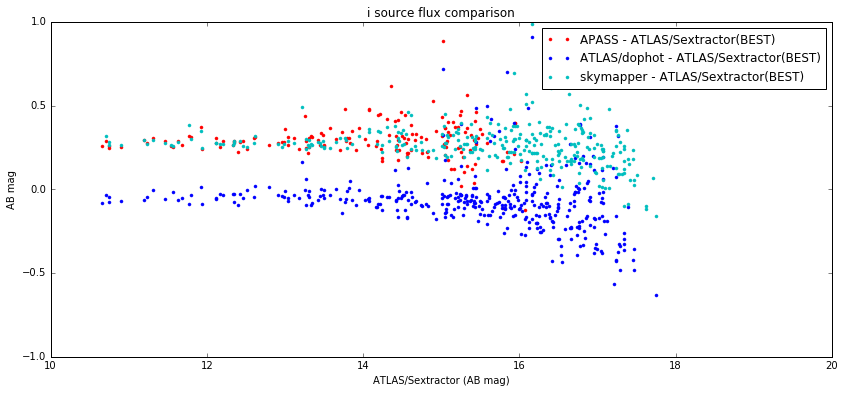

In [76]:
plt.figure(figsize=(14,6))

stys = ['r.','b.','c.']

for cati in range(len(cats)):
    plt.plot(jy2mag(secat.jy[indices_matching_srcs[cati,:]>0]),\
             jy2mag(cats[cati].jy[indices_matching_srcs[cati,indices_matching_srcs[cati,:]>0]])-jy2mag(secat.jy[indices_matching_srcs[cati,:]>0]),stys[cati],\
             label=str(catnames[cati])+' - ATLAS/Sextractor(BEST)',alpha=1)

plt.xlim([10,20])
plt.ylabel('AB mag')
plt.legend()
plt.ylim([-1,1])
plt.xlabel('ATLAS/Sextractor (AB mag)')
plt.title('i source flux comparison')

#plt.savefig('skymapper_vs_dophot_vs_se_'+sefluxname+'.png',bbox_inches='tight')

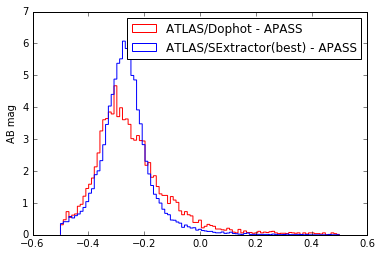

In [55]:
b = np.linspace(-.5,.5,100)

l1,l2 = 'ATLAS/Dophot - APASS','ATLAS/SExtractor(best) - APASS'
plt.ylabel('AB mag')

aa = plt.hist(jy2mag(dophot_cat.jy)[indices_of_matching_dophot_sources[indices_of_matching_dophot_sources>0]]-jy2mag(apass_cat.jy[indices_of_matching_dophot_sources>0]),b,histtype='step',normed=True,color='red',label=l1)
bb = plt.hist(jy2mag(secat.jy[indices_of_matching_sex_sources[indices_of_matching_sex_sources>0]])-jy2mag(apass_cat.jy[indices_of_matching_sex_sources>0]),b,histtype='step',normed=True,color='blue',label=l2)

plt.legend()